In [1]:
%load_ext autoreload
%autoreload 2   

In [59]:
import asyncio
import json
import socket

from qdm.server.comms import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [223]:
# SYSTEM SETTINGS 
await sys_query(dev="sys", cmd="set_system_tag", args=["hBN_RF_sensing"])

{'error': None, 'response': 'set attr'}

In [116]:
await sys_query(dev="sys", cmd="select_objective", args=["10x"])

{'error': None, 'response': None}

 ## Setting Attributes

In [117]:
# Setting attributes with the wrapper function
await set_rf(freq = 2860, power = -40)
await set_cam(exposure = 0.2, 
              bin = (2, 2), 
              trigger_mode = "int", 
              cooling = True, 
              image_size=(512, 512))

In [137]:
await sys_query(dev="cam", cmd="set_attr", attr="image_size", args=[(1024, 512)])
await sys_query(dev="cam", cmd="get_attr", attr="image_size")

{'error': 'Invalid request', 'response': 'no response', 'data': None}

In [155]:
await sys_query(dev="cam", cmd="set_attr", attr="bin", args=[(1, 1)])
await sys_query(dev="cam", cmd="get_attr", attr="bin")

{'error': None, 'response': 'attr', 'data': [1, 1]}

## Getting Attributes

In [152]:
rf_attrs = await sys_query(dev='rf', cmd='get_all_attrs')
print(rf_attrs)


rf_attrs_dev = await sys_query(dev='rf', cmd='get_all_attrs_dev')
print(rf_attrs_dev)

{'output': 0, 'freq': 2870, 'power': -50}
{'f': ' RF Frequency Now (MHz) 2870.00000000', 'W': ' RF Power (dBm) -50.000', 'V': ' Amp Calibration success? 0', 'Z': ' Temperature Comp (0=none, 1=on set, 2=1sec, 3=10sec) 0', 'w': ' Read Pwr Detector dBm (burst samples) -53.393', '&': ' RF Detector Mode Inst(0), Av(1), Pk(2) 0', 'a': ' VGA DAC Setting (0=min, 4000=max) 126', '~': ' RF Phase Step (0=minimum, 360.0=maximum) 0.0000', 'h': ' RF High(1) or Low(0) Power 0', 'E': ' PLL Chip En On(1) or Off(0) 0', 'U': ' PLL charge pump current 5', 'D': ' REF Doubler On(1) or Off(0) 0', 'i': ' Channel spacing (Hz) 10.000', 'x': ' Reference (external=0, int 27MHz=1, int 10MHz=2) 1', '*': ' PLL reference frequency (MHz) 27.00000000', 'l': ' Sweep lower frequency (MHz) 2750.00000000', 'u': ' Sweep upper frequency (MHz) 2950.00000000', 's': ' Sweep step size (MHz/%) 4.00000000', 't': ' Sweep step time (mS) 10.000', '[': ' Sweep amplitude low (dBm) -10.000', ']': ' Sweep amplitude high (dBm) -10.000', '

In [118]:
# Get the class attributes
cam_attrs = await sys_query(dev='cam', cmd='get_all_attrs')
print(cam_attrs)
# Get the device attributes 

cam_attrs_dev = await sys_query(dev='cam', cmd='get_all_attr_dev')
print(json.dumps(cam_attrs_dev, indent=4))


{'roi': [768.0, 1280.0, 768.0, 1280.0], 'bin': [2, 2], 'exposure': 0.2, 'image_size': [512, 512], 'data_size': [256, 256]}
{
    "AccumulateCount": 1,
    "AOIHBin": 2,
    "AOIHeight": 256,
    "AOILeft": 769,
    "AOIStride": 512,
    "AOITop": 769,
    "AOIVBin": 2,
    "AOIWidth": 256,
    "Baseline": 100,
    "ExposedPixelHeight": 20833,
    "FrameCount": 1,
    "ImageSizeBytes": 131072,
    "SensorHeight": 2048,
    "SensorWidth": 2048,
    "TimestampClock": 48500550321549,
    "TimestampClockFrequency": 40000000,
    "AlternatingReadoutDirection": false,
    "CameraAcquiring": false,
    "CameraPresent": true,
    "EventEnable": true,
    "FastAOIFrameRateEnable": false,
    "FullAOIControl": true,
    "IOInvert": false,
    "MetadataEnable": false,
    "MetadataFrame": true,
    "MetadataFrameInfo": true,
    "MetadataTimestamp": true,
    "Overlap": false,
    "RollingShutterGlobalClear": false,
    "ScanSpeedControlEnable": false,
    "SensorCooling": true,
    "SpuriousNoise

## Take camera image

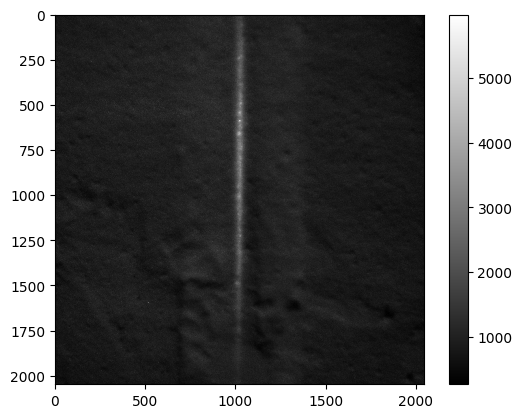

{'error': None, 'response': None}

In [39]:
await sys_query(dev='SYS', cmd='laser_output', args=[1])

await set_cam(exposure = 0.05, 
              bin = (1, 1), 
              trigger_mode = "int", 
              image_size=(2048, 2048))
# Get the image size
img_size = (await sys_query(dev='cam', cmd='get_attr', attr="data_size"))['data']

# get a single frame
image = await sys_query(dev='cam', cmd='get_frame', kwargs={"num_frames": 1})

# Plot the image
plt.figure()
plt.imshow(image.reshape((img_size[0], img_size[1])), cmap='gray', interpolation='none')
plt.colorbar()
plt.show()
await sys_query(dev='SYS', cmd='laser_output', args=[0])


In [40]:
np.save("bright_field_image_6GHz.npy", image.reshape((img_size[0], img_size[1])))

# Capture Video

In [205]:
await sys_query(dev='SYS', cmd='laser_output', args=[0])

{'error': None, 'response': None}

Text(0, 0.5, 'Intensity (cps)')

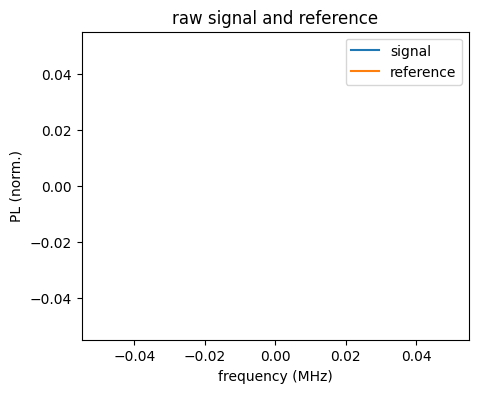

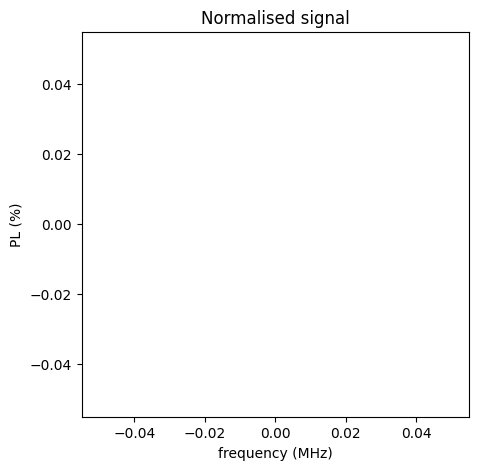

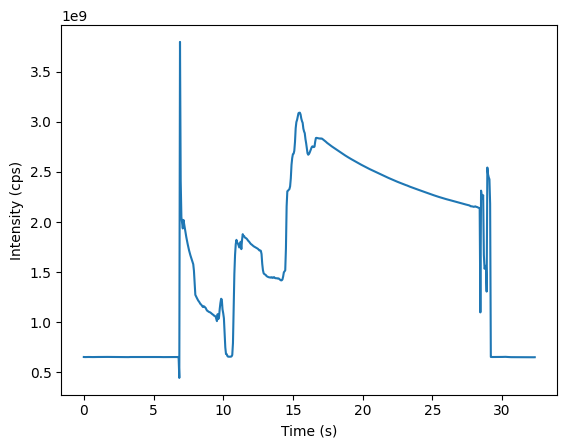

In [58]:
await set_cam(exposure = 0.05, 
              bin = (1, 1), 
              trigger_mode = "int", 
              image_size=(2048, 2048))

# turn the laser on
await sys_query(dev='SYS', cmd='laser_output', args=[1])
# Take the video
time_trace = await sys_query(dev='cam', cmd='video', kwargs={"blit": False})
# turn the laser off
await sys_query(dev='SYS', cmd='laser_output', args=[0])

# plot the time trace
plt.figure()
plt.plot(time_trace["time"], time_trace["intensity"])
plt.xlabel("Time (s)")
plt.ylabel("Intensity (cps)")


# Measurements

In [130]:
# Set up the devices for the experiment
await set_rf(freq=2870, power=-50, output=1)
# prepare the camera
await set_cam(exposure = 0.05, 
              bin = (1, 1), 
              trigger_mode = "int", 
              image_size=(512, 512))
await sys_query(dev='SYS', cmd='get_attr', attr='pixel_size')

{'error': None, 'response': 'attr', 'data': 4e-07}

In [237]:
await sys_query(dev='SYS', cmd='select_objective', args=["4x"])
await sys_query(dev='SYS', cmd='get_attr', attr='objective')

{'error': None, 'response': 'attr', 'data': '4x'}

In [72]:

await set_cam(exposure = 0.02, 
              bin = (1, 1), 
              trigger_mode = "int", 
              image_size=(2048, 100))

from qdm.measurements.esr_server import ESR
# create an object of the ODMR measurement
# -30 dBm is plently of power for the ODMR
odmr = ESR(
            int_time = 20e-3,
            avg_per_point = 4,
            freq_center= 4000,
            freq_range = 2000,
            freq_num = 201,
            rf_power = 0,
            esr_type= "cw",
            ref_bool = True,
            ref_type = "no_rf") 

In [73]:
await odmr.start(num_sweeps=2000)

started measurement


  8%|▊         | 166/2000 [1:41:28<36:50:37, 72.32s/it]

The camera did not return the images
attmepting to continue with the measurement


 11%|█▏        | 226/2000 [2:20:22<35:43:14, 72.49s/it]

The camera did not return the images
attmepting to continue with the measurement


 39%|███▉      | 784/2000 [8:35:10<27:13:24, 80.60s/it]

The camera did not return the images
attmepting to continue with the measurement


 72%|███████▏  | 1447/2000 [16:26:22<6:16:57, 40.90s/it] 

Measurement stopped


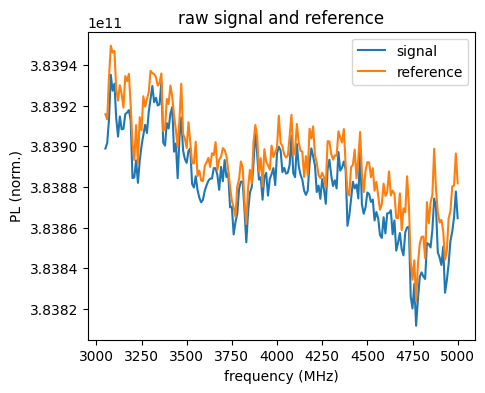

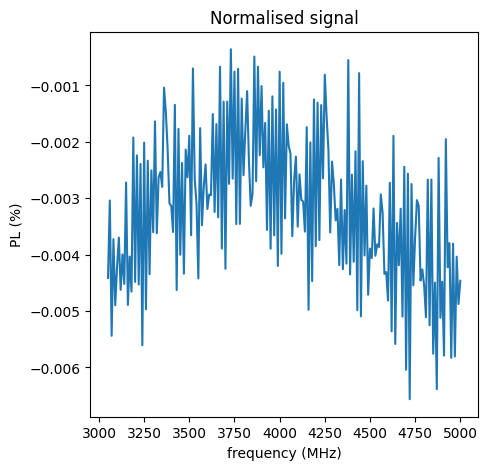

In [74]:
await odmr.plot_spectrum(bfit=False, remove_start=5)

In [75]:
await odmr.save(save_images = True)

None C:/ExperimentalData/ False
C:/ExperimentalData/2024/2024_02/16_/000_esr
Data stored successfully!


In [ ]:
p_odmr = ESR(
            int_time = 20e-3,
            avg_per_point = 1,
            freq_center= 2690,
            freq_range = 100,
            freq_num = 101,
            rf_power = -46,
            laser_dur = 2e-6,
            laser_delay= 300e-9,
            rf_dur = 400e-9,
            rf_delay= 30e-9,
            laser_to_rf_delay= 20e-9,
            esr_type= "pulsed",
            ref_bool = True,
            ref_type = "no_rf") 


In [69]:
await p_odmr.start(num_sweeps=2)

NameError: name 'p_odmr' is not defined

In [ ]:
p_odmr.plot_spectrum(bfit=True)

In [ ]:
await p_odmr.plot_image(b_norm=True, cmap='viridis')

In [ ]:
await p_odmr.save(save_images=False)

In [ ]:
p_odmr.clear_data()

In [ ]:
p_odmr.sig

# Q-control measurements

In [ ]:
from qdm.measurements.rabi_server import RABI 

# time_start min value is 12 ns

rabi = RABI( int_time = 20e-3,
            time_start= 12e-9,
            time_stop= 300e-9,
            time_num= 101,
            avg_per_point = 1,
            rf_freq= 2687.93,
            rf_power = -20,
            laser_dur = 2e-6,
            laser_delay= 200e-9,
            rf_delay= 50e-9,
            laser_to_rf_delay= 0,
            ref_bool = True,
            ref_type = "no_rf")

In [ ]:
await rabi.start(num_sweeps=2)

In [ ]:
rabi.plot_spectra()

In [ ]:
rabi.plot_fft()

In [ ]:
# Save rabi data
# Did not work, have to double check save definition (Giannis) 
# await rabi.save(save_images=False)

# Routines

In [ ]:
# These are scripts or functions that we might use to 
# take several measurements

from qdm.routines.parameter_sweep_server import Param_sweep

meas_sweep = Param_sweep(p_odmr,
                         meas_sweeps = 1,
                         meas_param= "rf_power",
                         min_val=-60,
                         max_val=-30,
                         num=11,
                         bfit=False)


In [ ]:
await meas_sweep.start()

In [ ]:
meas_sweep.plot()

In [ ]:
p_odmr.rf_dur

In [ ]:
p_odmr.rf_power = -32
meas_sweep_2 = Param_sweep(p_odmr,
                         meas_sweeps = 1,
                         meas_param= "rf_dur",
                         min_val=100e-9,
                         max_val=1000e-9,
                         num=5,
                         bfit=False)

In [ ]:
await meas_sweep_2.start()

In [ ]:
meas_sweep_2.plot()

# Giannis' routine

In [ ]:
# Set standard parameters for the ODMR measurement
p_odmr = ESR(
            int_time = 20e-3,
            avg_per_point = 1,
            freq_center= 2690,
            freq_range = 100,
            freq_num = 101,
            rf_power = -46,
            laser_dur = 2e-6,
            laser_delay= 300e-9,
            rf_dur = 400e-9,
            rf_delay= 30e-9,
            laser_to_rf_delay= 20e-9,
            esr_type= "pulsed",
            ref_bool = True,
            ref_type = "no_rf") 

# Set the parameter min and max values
parameter_min_val = -60;
parameter_max_val = -30;

# Parameter sweep 
meas_sweep_3 = Param_sweep(p_odmr,
                         meas_sweeps = 1,
                         meas_param= "rf_power",
                         min_val=-60,
                         max_val=-30,
                         num=10,
                         bfit=False)
await meas_sweep_3.start()
meas_sweep_3.plot()


## Rabi sweeps

In [ ]:
rf_freq= 2687.93

rabi_sweep = Param_sweep(rabi,
                         meas_sweeps = 1,
                         meas_param= "rf_freq",
                         min_val=2670,
                         max_val=2700,
                         num=2,
                         bfit=False)

In [ ]:
await rabi_sweep.start()

In [ ]:
rabi_sweep.plot(sig_type="norm", remove_end=20)

In [ ]:
await rabi_sweep.save()